# Bagging for data valuation

This notebook introduces the Data-OOB method, an implementation based on a publication from Kwon and Zou "Data-OOB: Out-of-bag Estimate as a Simple and Efficient Data Value" ICML 2023 , using pyDVL.
https://proceedings.mlr.press/v202/kwon23e.html

The objective of this paper is mainly to overcome the computational bottleneck of shapley-based data valuation methods that require to fit a significant number of models to accurately estimate marginal contributions.
The algorithms computes data values from out of bag estimates using a bagging model.

The value can be interpreted as a partition of the OOB estimate, which is originally introduced to estimate the prediction error. This OOB estimate is given as:

$$
\sum_{i=1}^n\frac{\sum_{b=1}^{B}\mathbb{1}(w_{bi}=0)T(y_i, \hat{f}_b(x_i))}{\sum_{b=1}^{B}
\mathbb{1}
(w_{bi}=0)}
$$


## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from pydvl.value import compute_data_oob
from pydvl.utils import Dataset, Utility, Scorer
from pydvl.reporting.scores import compute_removal_score
from pydvl.reporting.plots import shaded_mean_std, plot_best_worst, plot_best_worst_class_imbalance, compute_best_worst_scores, plot_methods_linreg
from pydvl.value.result import ValuationResult

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [2]:
import pandas as pd
from sklearn.datasets import load_iris

data = Dataset.from_sklearn(load_iris())

In [3]:

#model = KNeighborsClassifier(n_neighbors=5)
model = DecisionTreeClassifier(max_depth=5,)
#model = LogisticRegression()
utility = Utility(model, data, Scorer("balanced_accuracy", default=0.0))

# Base estimator

In [4]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process.kernels import RBF

In [5]:

scorer = Scorer("balanced_accuracy", default=0.0)

dict_utilities = {}
#utility = Utility(KNeighborsClassifier(n_neighbors=5), data, scorer)
#dict_utilities["KNN"] = utility
utility = Utility(DecisionTreeClassifier(max_depth=2,), data, scorer)
dict_utilities["DecisionTreeShallow"] = utility
utility = Utility(DecisionTreeClassifier(max_depth=20,), data, scorer)
dict_utilities["DecisionTreeDeep"] = utility
#utility = Utility(LogisticRegression(), data, scorer)
#dict_utilities["LogisticRegression"] = utility
#utility = Utility(GaussianProcessClassifier(1.0 * RBF(1.0)), data, scorer)
#dict_utilities["GaussianProcess"] = utility
#utility = Utility(GaussianNB(), data, scorer)
#dict_utilities["GaussianNB"] = utility
#utility = Utility(MLPClassifier(), data, scorer)
#dict_utilities["MLPClassifier"] = utility
utility = Utility(RandomForestClassifier(max_depth=5, n_estimators=10), data, scorer)
dict_utilities["RandomForest"] = utility
#utility = Utility(AdaBoostClassifier(), data, scorer)
#dict_utilities["AdaBoost"] = utility
#utility = Utility(LGBMClassifier(verbose= -1), data, scorer)
#dict_utilities["LGBM"] = utility

dict_utilities.keys()

dict_keys(['DecisionTreeShallow', 'DecisionTreeDeep', 'RandomForest'])

# Fix OOB parameters

In [6]:
def oob_func(utility, model_name):
    return(compute_data_oob(dict_utilities[model_name], n_est=100, max_samples=0.5, progress=False))
kwargs_list = [{"model_name":m} for m in dict_utilities.keys()]

In [7]:
area_under_curve_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
area_under_curve_worst = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
percent_above_random_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
percent_above_random_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))

In [8]:
def compute_random_baseline_best_worst_mean(n_iter, utility_eval, removal_percentages):
    random_vals = [ValuationResult.from_random(size=len(utility.data)) for _ in range(n_iter)]
    best_random_score = [compute_removal_score(u=utility,
                                            values=vals,
                                            percentages=removal_percentages,
                                            remove_best=True,) for vals in random_vals]
    df_random_best = pd.DataFrame(best_random_score)
    df_random_best = df_random_best.mean()

    worst_random_score = [compute_removal_score(u=utility_eval,
                                            values=vals,
                                            percentages=removal_percentages,
                                            remove_best=False,) for vals in random_vals]
    df_random_worst = pd.DataFrame(worst_random_score)
    df_random_worst = df_random_worst.mean()
    return(df_random_best, df_random_worst)

In [9]:
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.05)

area_under_curve_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
area_under_curve_worst = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
percent_above_random_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
percent_above_random_worst = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
diff_random_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
diff_random_worst = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
single_best_gain_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
single_best_gain_worst = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
max_accuracy_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
max_accuracy_worst = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
idxmax_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
idxmax_worst = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))

for k in kwargs_list:
    model_name = k["model_name"]
    utility_eval = dict_utilities[model_name]
    df_random_best, df_random_worst = compute_random_baseline_best_worst_mean(n_iter, utility_eval, removal_percentages)
    best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, removal_percentages, n_iter, oob_func, kwargs_list,f_name="", return_values=True)
    best_scores_df.loc[:,"method_name"] = best_scores_df.loc[:,"method_name"].apply(lambda x: "_".join(x.split("_")[1:]))
    worst_scores_df.loc[:,"method_name"] = worst_scores_df.loc[:,"method_name"].apply(lambda x: "_".join(x.split("_")[1:]))
    df_mean_best = best_scores_df.groupby("method_name").mean()
    df_mean_worst = worst_scores_df.groupby("method_name").mean()

    area_under_curve_best.loc[:,model_name] = df_mean_best.sum(axis=1)/len(removal_percentages)
    area_under_curve_worst.loc[:,model_name] = df_mean_worst.sum(axis=1)/len(removal_percentages)

    best_compare_random = df_mean_best.apply(lambda row: np.array(row.values < df_random_best, dtype=int), axis=1)
    worst_compare_random = df_mean_worst.apply(lambda row: np.array(row.values > df_random_worst, dtype=int), axis=1)
    percent_above_random_best.loc[:,model_name] = best_compare_random.apply(lambda x: np.mean(x))
    percent_above_random_worst.loc[:,model_name] = worst_compare_random.apply(lambda x: np.mean(x))

    diff_random_best.loc[:,model_name] = df_mean_best.apply(lambda row: sum(np.array(row.values - df_random_best, dtype=float)* np.array(row.values < df_random_best, dtype=int)), axis=1)
    diff_random_worst.loc[:,model_name] = df_mean_worst.apply(lambda row: sum(np.array(row.values - df_random_worst, dtype=float)* np.array(row.values > df_random_worst, dtype=int)), axis=1)

    single_best_gain_best.loc[:,model_name] = df_mean_best.apply(lambda row: min(np.array(row.values - df_random_best, dtype=float)), axis=1)
    single_best_gain_worst.loc[:,model_name] = df_mean_worst.apply(lambda row: max(np.array(row.values - df_random_worst, dtype=float)), axis=1)

    max_accuracy_best.loc[:,model_name] = df_mean_best.apply(lambda row: max(row.values), axis=1)
    max_accuracy_worst.loc[:,model_name] = df_mean_worst.apply(lambda row: max(row.values), axis=1)

    idxmax_best.loc[:,model_name] = df_mean_best.idxmax(axis=1)
    idxmax_worst.loc[:,model_name] = df_mean_worst.idxmax(axis=1)

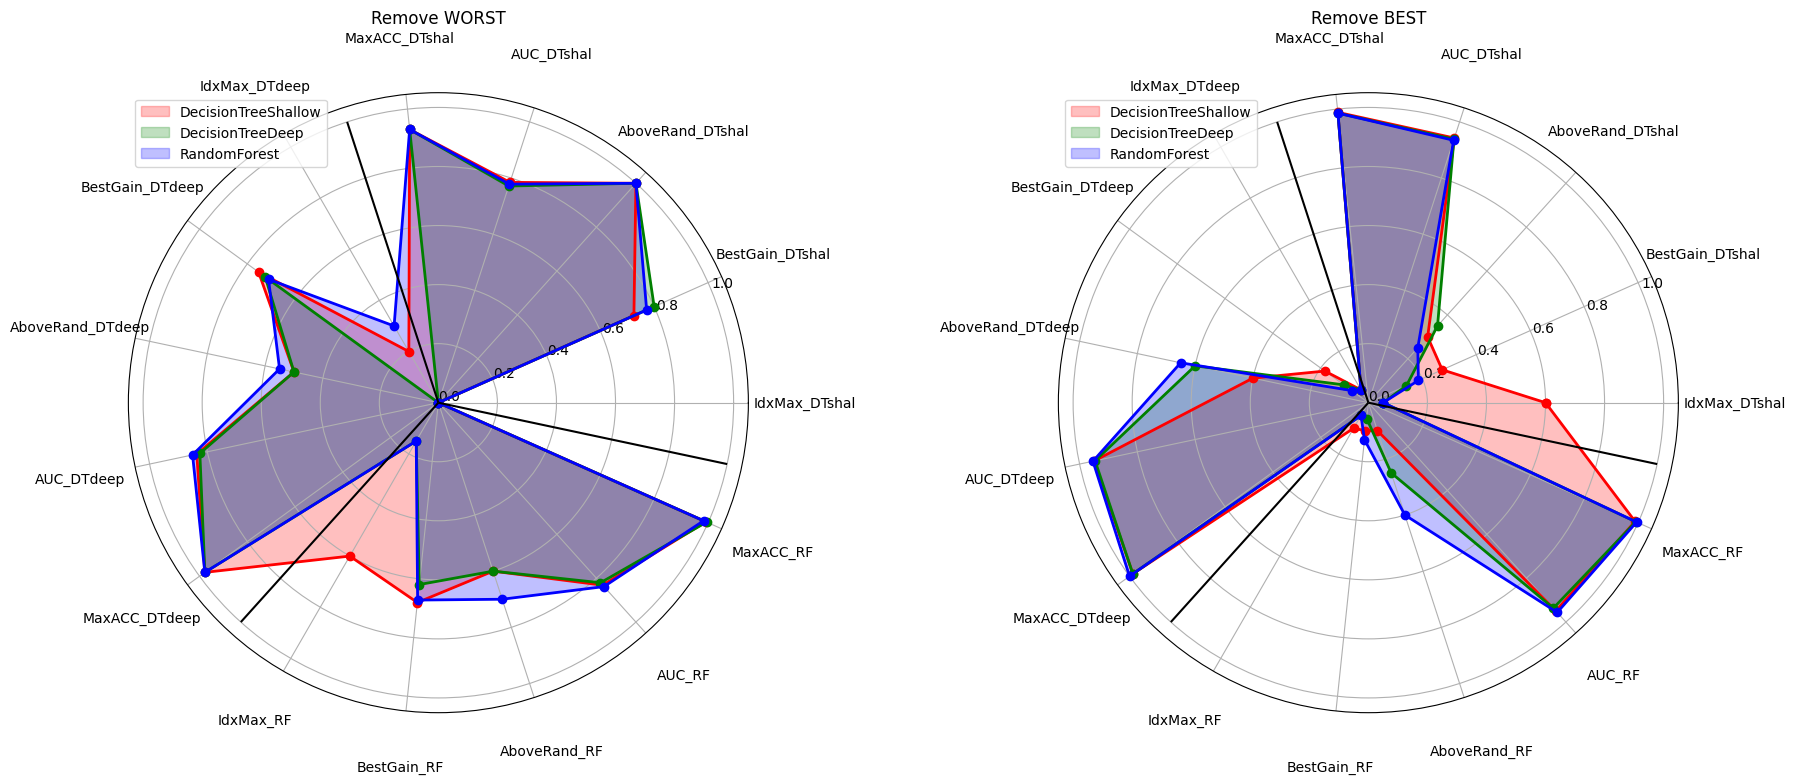

In [15]:
all_metrics_names = ["AUC", "AboveRand", "BestGain", "MaxACC", "IdxMax"]
all_metrics_worst = [ idxmax_worst, single_best_gain_worst, percent_above_random_worst, area_under_curve_worst , max_accuracy_worst]
all_metrics_best = [ idxmax_best, -single_best_gain_best, percent_above_random_best, area_under_curve_best , max_accuracy_best]

all_metrics_names = ["IdxMax", "BestGain", "AboveRand","AUC",  "MaxACC", ]


fig = plt.figure(figsize = [20,20])
for name, all_metrics, ax in zip(["Remove WORST", "Remove BEST"], [all_metrics_best, all_metrics_worst], [fig.add_subplot(121, polar=True), fig.add_subplot(122, polar=True)]):

    for color, chosen_dataval in zip(['r','g','b'],idxmax_best.columns ):
        values = [metric.loc[chosen_dataval, col]    for col in  idxmax_best.columns for metric in all_metrics]
        names = [str(metric)+f"_{col}"    for col in ["DTshal", "DTdeep", "RF"] for metric in all_metrics_names]



        angles = np.linspace(0, 2*np.pi, len(values), endpoint=False)

        values = np.concatenate((values,[values[0]]))
        angles = np.concatenate((angles,[angles[0]]))
        
        ax.vlines([0], 0, [0], colors='black', zorder=3)
        ax.plot(angles, values, color+'o-', linewidth=2)
        ax.fill(angles, values,color=color, alpha=0.25, label=chosen_dataval)
        ax.set_thetagrids(angles[:-1] * 180/np.pi, names)
        ax.tick_params(pad=30)
        ax.set_yticks(np.linspace(0,1,6))
        ax.set_title(name)
        ax.grid(True)
    for ang in np.linspace(0,2*np.pi, len(idxmax_best.columns), endpoint=False):
        ax.vlines([0,ang-(2*np.pi/len(idxmax_best.columns)/(len(all_metrics_names)))/2], 0, [0,1], colors='black', zorder=3)

    ax.legend(loc=2)


plt.subplots_adjust(wspace=0.5)

In [84]:
len(angles),len(stats)

(6, 6)

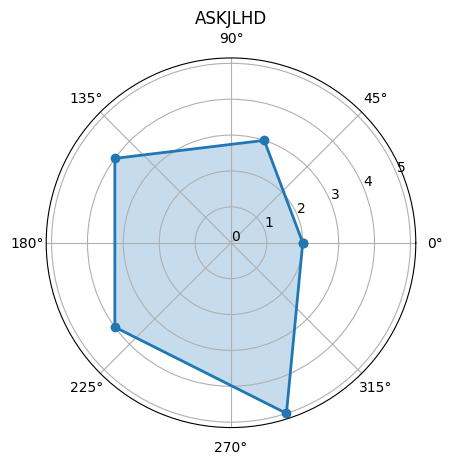

In [82]:

labels=['Siege', 'Initiation', 'Crowd_control', 'Wave_clear', 'Objective_damage']
markers = [0, 1, 2, 3, 4, 5]
str_markers = ["0", "1", "2", "3", "4", "5"]


name = "ASKJLHD"
stats = [2,3,4,4,5]


angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
stats = np.concatenate((stats,[stats[0]]))
angles = np.concatenate((angles,[angles[0]]))

fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, stats, 'o-', linewidth=2)
ax.fill(angles, stats, alpha=0.25)
#ax.set_thetagrids(angles * 180/np.pi, labels)
plt.yticks(markers)
ax.set_title(name)
ax.grid(True)


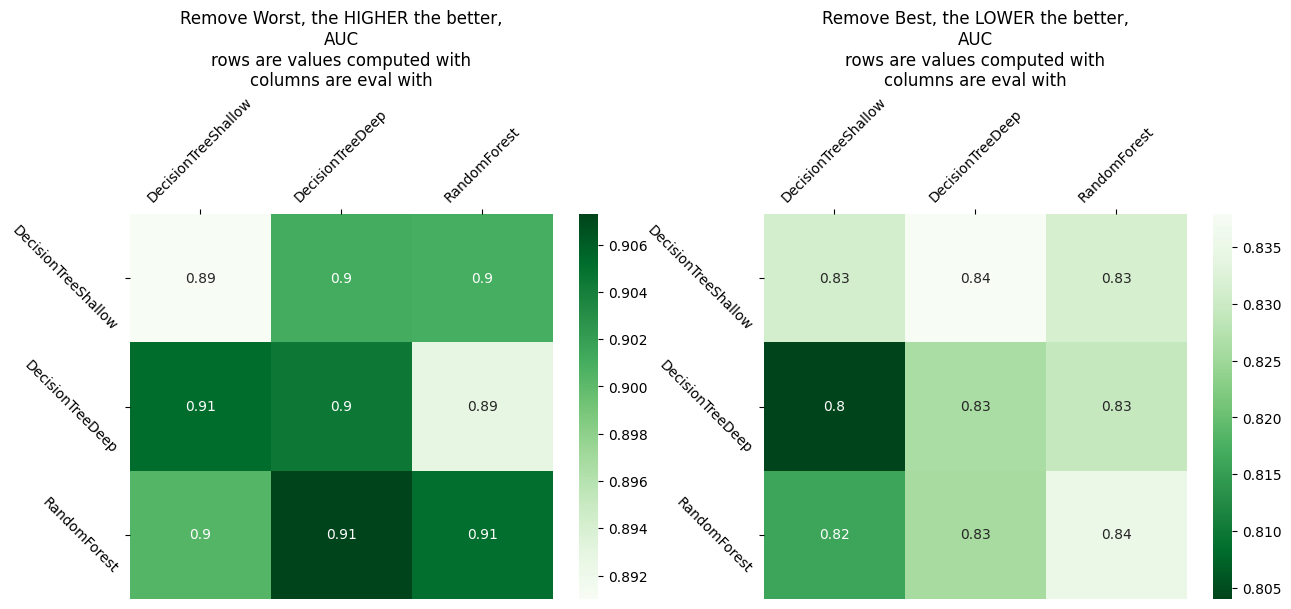

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize =[15,5])
col_order = list(area_under_curve_best.columns)

sns.heatmap(area_under_curve_worst.loc[col_order,col_order], annot=True,ax=ax[0], cmap="Greens")
sns.heatmap(area_under_curve_best.loc[col_order,col_order], annot=True,ax=ax[1], cmap="Greens_r")

ax[0].xaxis.tick_top()
ax[0].set_title("Remove Worst, the HIGHER the better,\nAUC\nrows are values computed with\ncolumns are eval with")
ax[0].set_xticklabels(col_order, rotation = 45)
ax[0].set_yticklabels(col_order, rotation = -45)
ax[1].xaxis.tick_top()
ax[1].set_title("Remove Best, the LOWER the better,\nAUC\nrows are values computed with\ncolumns are eval with")
ax[1].set_xticklabels(col_order, rotation = 45)
ax[1].set_yticklabels(col_order, rotation = -45)

plt.savefig("./figures/auc.png", bbox_inches='tight')

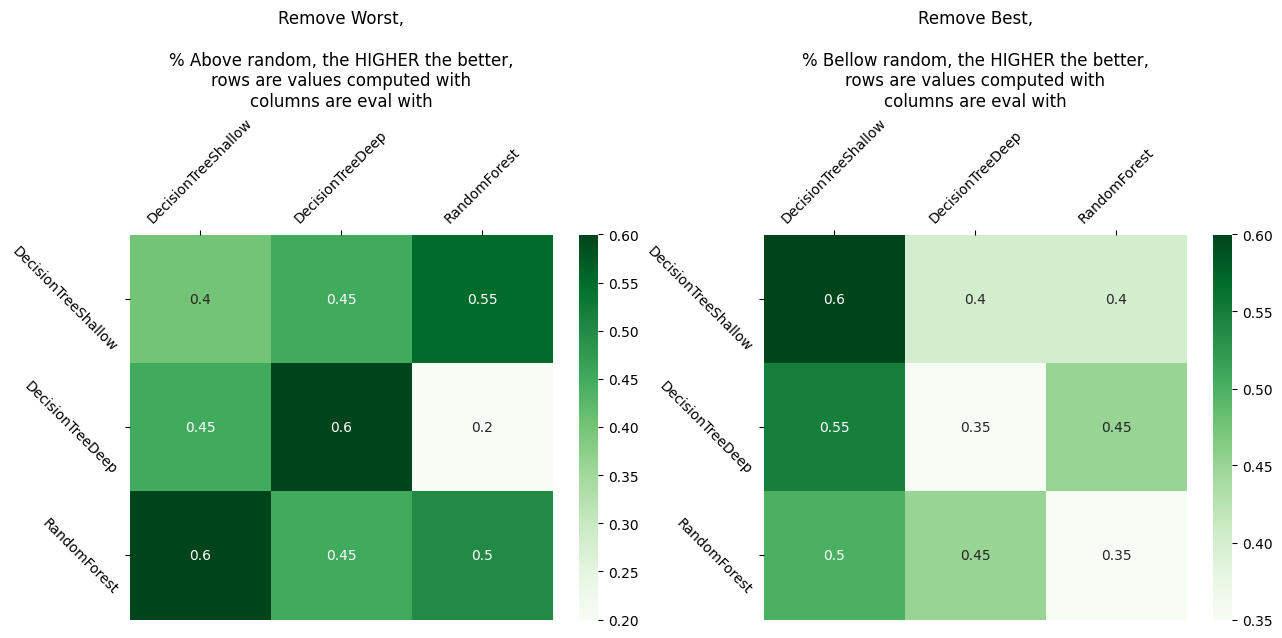

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize =[15,5])
col_order = list(area_under_curve_best.columns)


sns.heatmap(percent_above_random_worst.loc[col_order,col_order], annot=True,ax=ax[0], cmap = "Greens")
sns.heatmap(percent_above_random_best.loc[col_order,col_order], annot=True,ax=ax[1], cmap = "Greens")

ax[0].xaxis.tick_top()
ax[0].set_title("Remove Worst,\n\n% Above random, the HIGHER the better,\nrows are values computed with\ncolumns are eval with")
ax[0].set_xticklabels(col_order, rotation = 45)
ax[0].set_yticklabels(col_order, rotation = -45)
ax[1].xaxis.tick_top()
ax[1].set_title("Remove Best,\n\n% Bellow random, the HIGHER the better,\nrows are values computed with\ncolumns are eval with")
ax[1].set_xticklabels(col_order, rotation = 45)
ax[1].set_yticklabels(col_order, rotation = -45)

plt.savefig("./figures/percent_above_random.png", bbox_inches='tight')

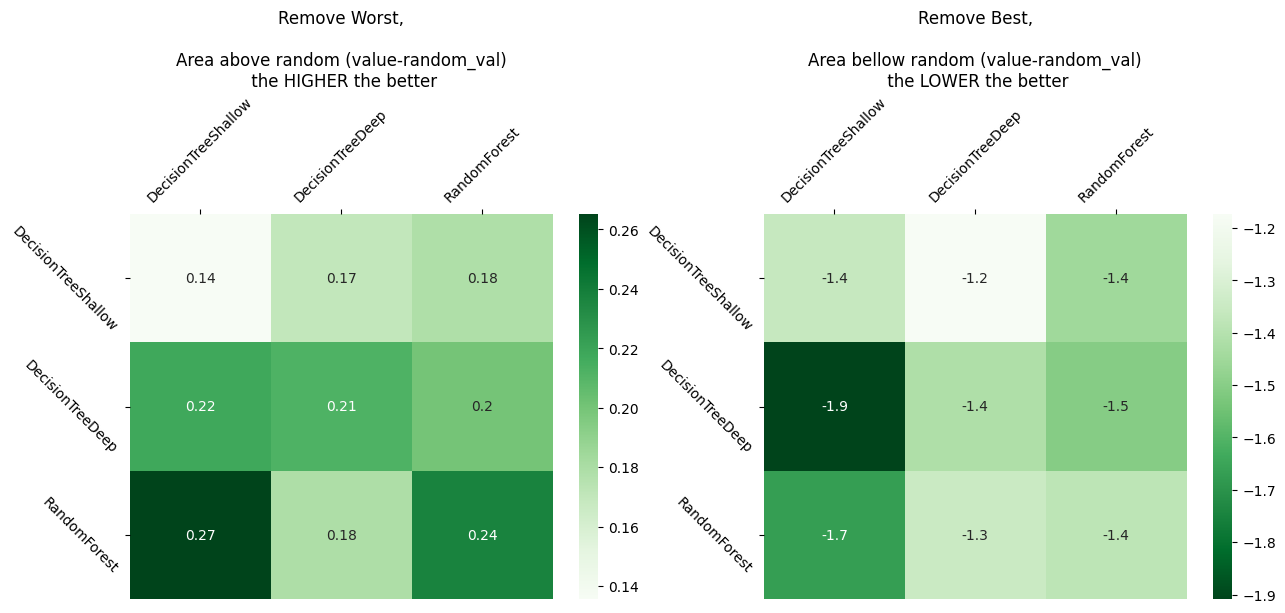

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize =[15,5])
col_order = list(area_under_curve_best.columns)

sns.heatmap(diff_random_worst.loc[col_order,col_order], annot=True,ax=ax[0], cmap = 'Greens')
sns.heatmap(diff_random_best.loc[col_order,col_order], annot=True,ax=ax[1], cmap = 'Greens_r')

ax[0].xaxis.tick_top()
ax[0].set_title("Remove Worst,\n\nArea above random (value-random_val)\n the HIGHER the better")
ax[0].set_xticklabels(col_order, rotation = 45)
ax[0].set_yticklabels(col_order, rotation = -45)
ax[1].xaxis.tick_top()
ax[1].set_title("Remove Best,\n\nArea bellow random (value-random_val)\n the LOWER the better")
ax[1].set_xticklabels(col_order, rotation = 45)
ax[1].set_yticklabels(col_order, rotation = -45)
plt.savefig("./figures/diff_random.png", bbox_inches='tight')

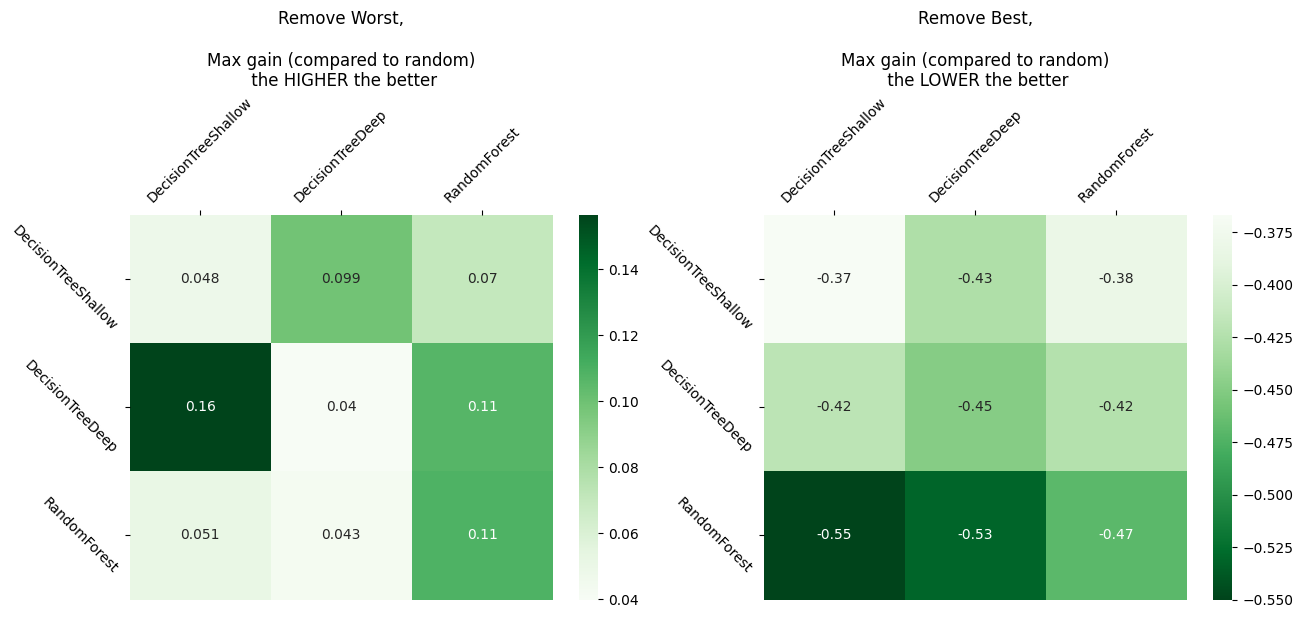

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize =[15,5])
col_order = list(area_under_curve_best.columns)

sns.heatmap(single_best_gain_worst.loc[col_order,col_order], annot=True,ax=ax[0], cmap = 'Greens')
sns.heatmap(single_best_gain_best.loc[col_order,col_order], annot=True,ax=ax[1], cmap = 'Greens_r')

ax[0].xaxis.tick_top()
ax[0].set_title("Remove Worst,\n\nMax gain (compared to random)\n the HIGHER the better")
ax[0].set_xticklabels(col_order, rotation = 45)
ax[0].set_yticklabels(col_order, rotation = -45)
ax[1].xaxis.tick_top()
ax[1].set_title("Remove Best,\n\nMax gain (compared to random)\n the LOWER the better")
ax[1].set_xticklabels(col_order, rotation = 45)
ax[1].set_yticklabels(col_order, rotation = -45)

plt.savefig("./figures/best_gain.png", bbox_inches='tight')

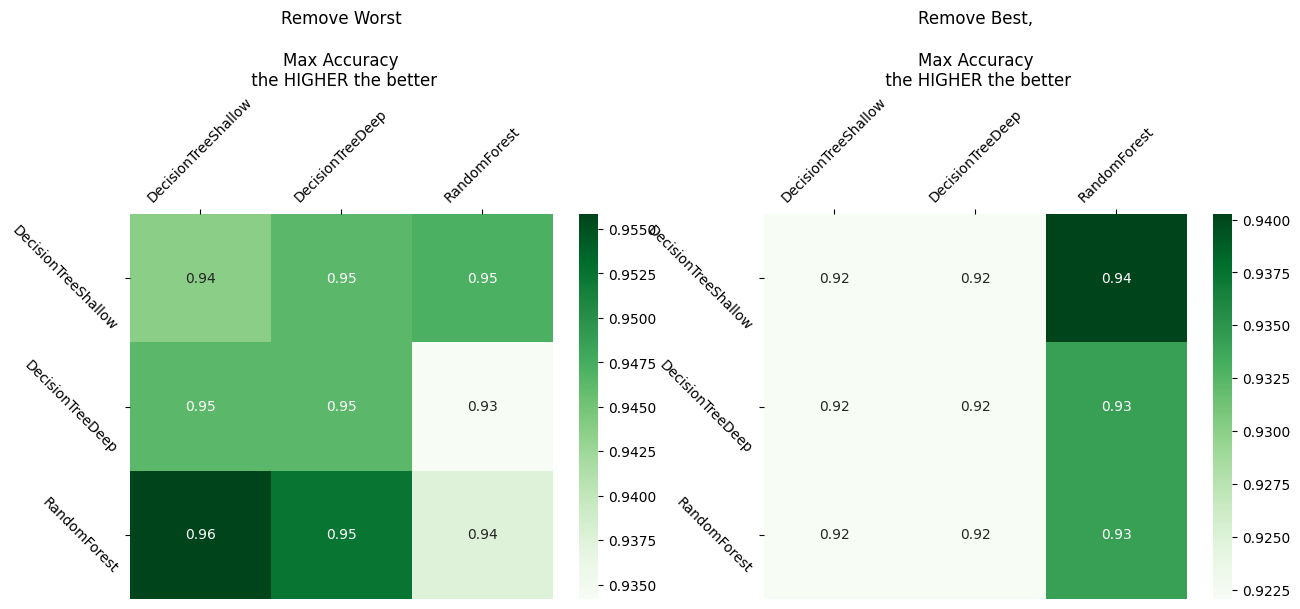

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize =[15,5])
col_order = list(area_under_curve_best.columns)
sns.heatmap(max_accuracy_best.loc[col_order,col_order], annot=True,ax=ax[1], cmap = 'Greens')
sns.heatmap(max_accuracy_worst.loc[col_order,col_order], annot=True,ax=ax[0], cmap = 'Greens')

ax[1].xaxis.tick_top()
ax[1].set_title("Remove Best,\n\nMax Accuracy\n the HIGHER the better")
ax[1].set_xticklabels(col_order, rotation = 45)
ax[1].set_yticklabels(col_order, rotation = -45)
ax[0].xaxis.tick_top()
ax[0].set_title("Remove Worst\n\nMax Accuracy\n the HIGHER the better")
ax[0].set_xticklabels(col_order, rotation = 45)
ax[0].set_yticklabels(col_order, rotation = -45)
plt.savefig("./figures/best_gain.png", bbox_inches='tight')

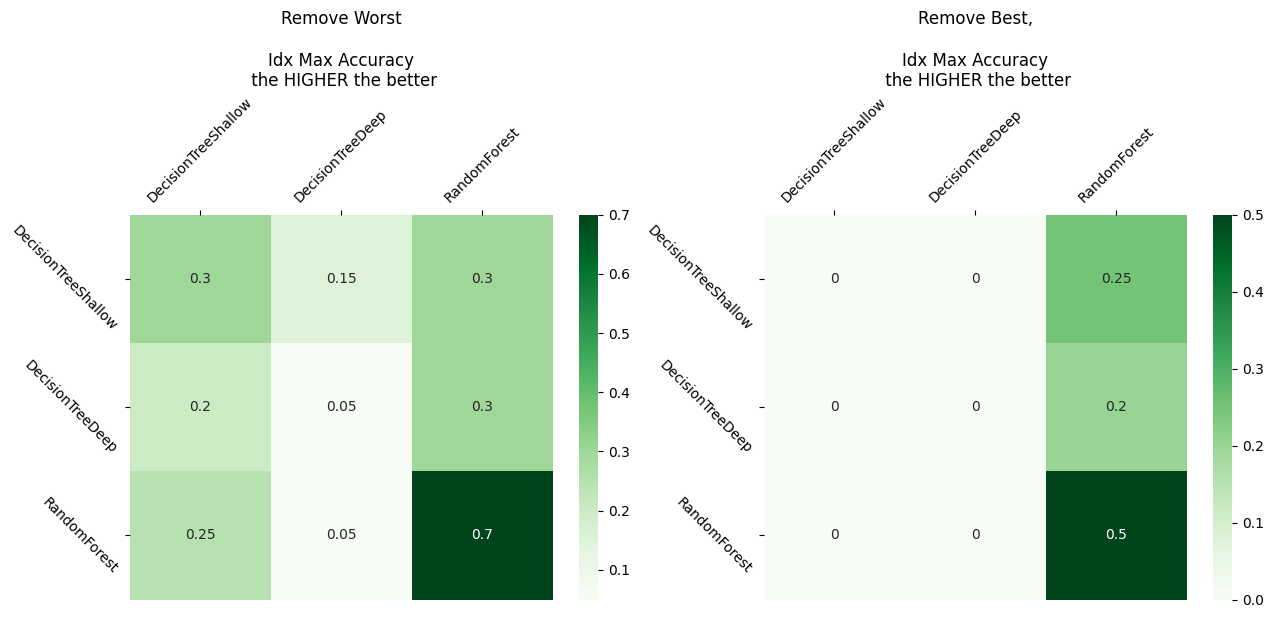

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize =[15,5])
col_order = list(area_under_curve_best.columns)

sns.heatmap(idxmax_worst.loc[col_order,col_order], annot=True,ax=ax[0], cmap = 'Greens')
sns.heatmap(idxmax_best.loc[col_order,col_order], annot=True,ax=ax[1], cmap = 'Greens')

ax[0].xaxis.tick_top()
ax[0].set_title("Remove Worst\n\nIdx Max Accuracy\n the HIGHER the better")
ax[0].set_xticklabels(col_order, rotation = 45)
ax[0].set_yticklabels(col_order, rotation = -45)
ax[1].xaxis.tick_top()
ax[1].set_title("Remove Best,\n\nIdx Max Accuracy\n the HIGHER the better")
ax[1].set_xticklabels(col_order, rotation = 45)
ax[1].set_yticklabels(col_order, rotation = -45)

plt.savefig("./figures/best_gain.png", bbox_inches='tight')

# Validate previous results

In [16]:
def oob_func_test(utility, _):
    return(compute_data_oob(utility, n_est=30, max_samples=0.8, progress=False))

In [17]:
dict_utilities.keys()

dict_keys(['DecisionTreeShallow', 'DecisionTreeDeep', 'RandomForest'])

In [18]:
model = LogisticRegression()
utility = dict_utilities["RandomForest"]
utility_eval = dict_utilities["RandomForest"]
n_iter = 10
removal_percentages = np.arange(0, 0.99, 0.01)

best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, removal_percentages, n_iter, oob_func_test, kwargs_list = [{"_":"_"}], return_values=True)

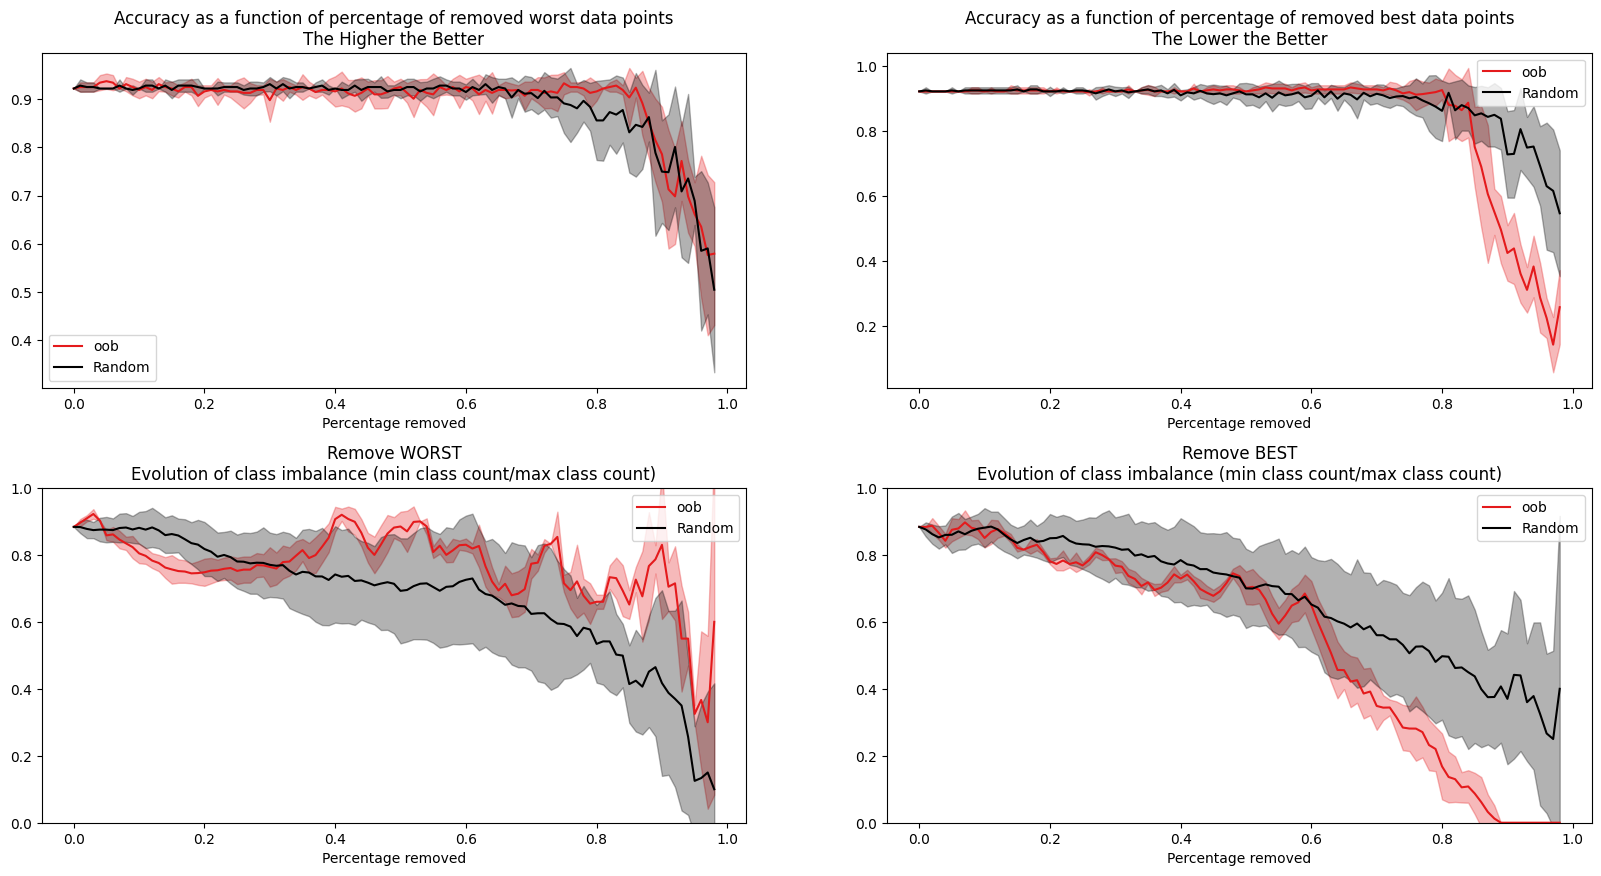

In [19]:
plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility_eval, palette_name="Set1", random_run=True)

# Plot best/worst points in data space

In [20]:
dict_utilities.keys()

dict_keys(['DecisionTreeShallow', 'DecisionTreeDeep', 'RandomForest'])

In [21]:
from sklearn.decomposition import PCA

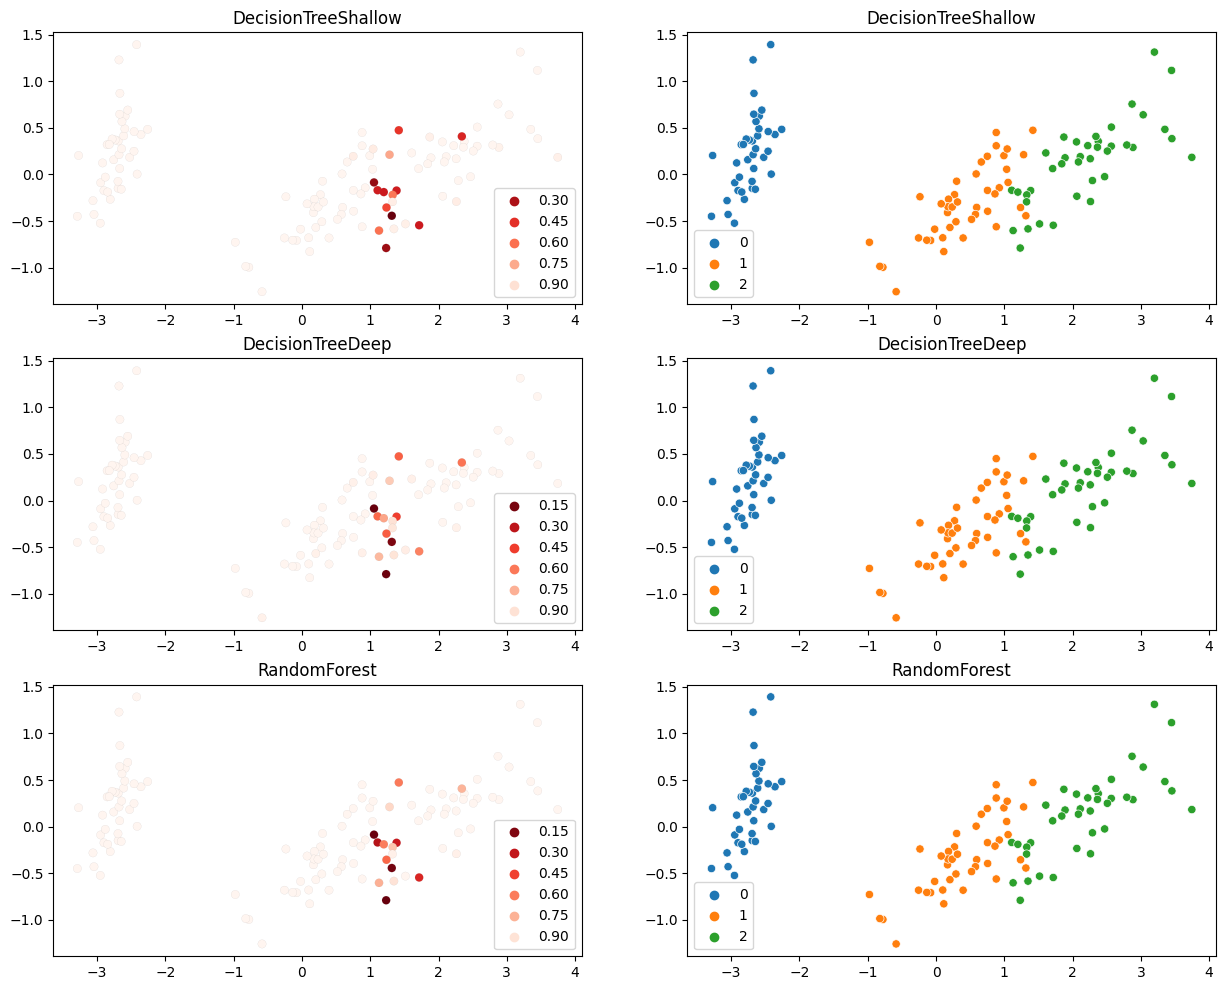

In [22]:
df = pd.DataFrame(index=utility.data.indices, data=utility.data.x_train, columns=utility.data.feature_names)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df)

fig, ax = plt.subplots(nrows=len(dict_utilities.keys()), ncols=2, figsize= [15,4*len(dict_utilities.keys())])

from sklearn.decomposition import PCA
for i, model_name in enumerate(dict_utilities.keys()):
    vals = compute_data_oob(dict_utilities[model_name], n_est=100, max_samples=0.8, progress=False)
    ax[i,0].set_title(model_name)
    ax[i,1].set_title(model_name)
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=vals.values[vals.indices], palette="Reds_r", linewidth=0.05, edgecolor='grey', ax=ax[i,0])
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=utility.data.y_train[utility.data.indices], palette="tab10", ax=ax[i,1])

In [23]:
from sklearn.manifold import TSNE

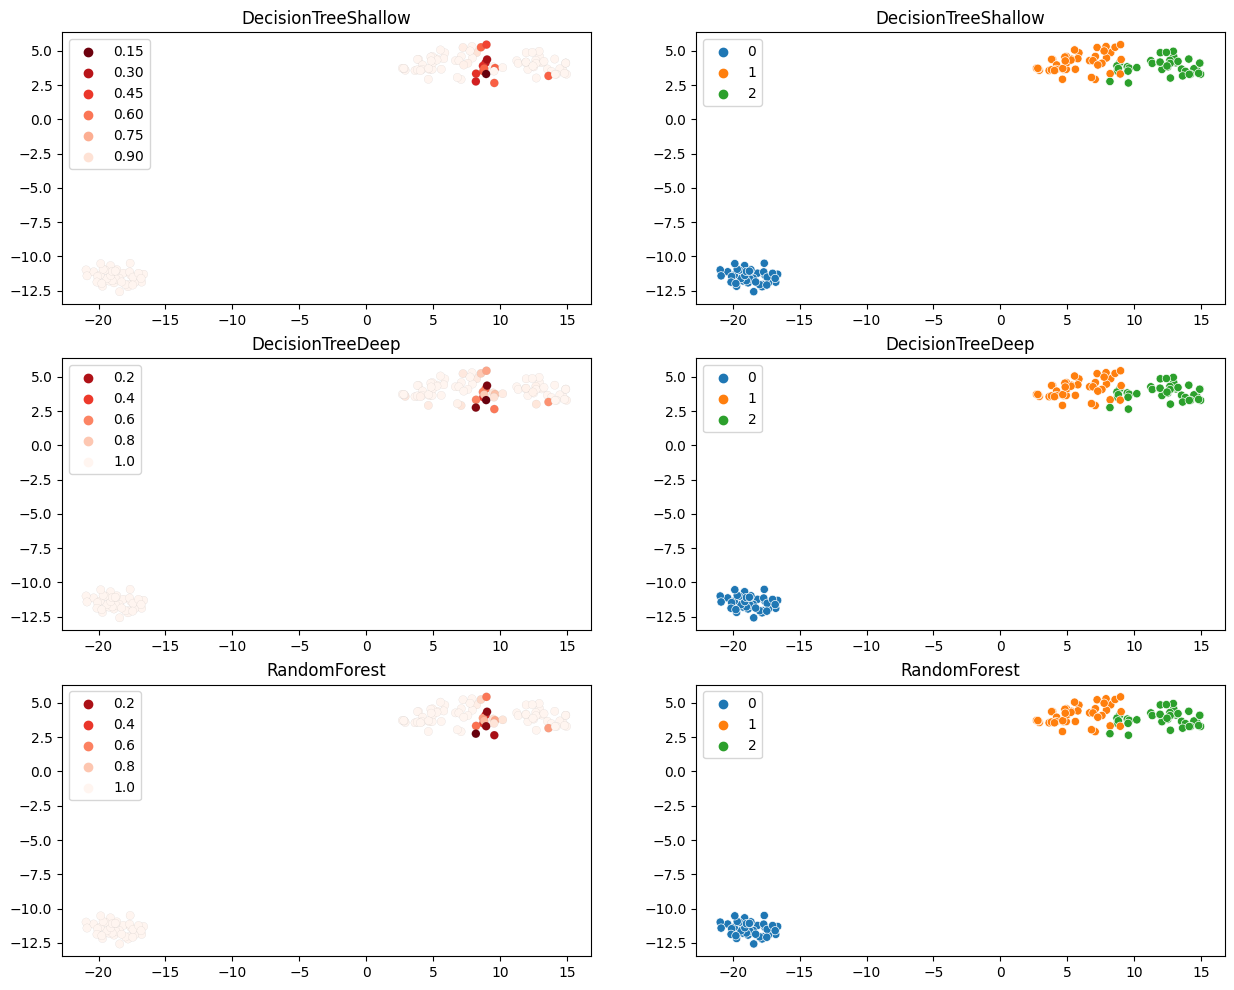

In [24]:
df = pd.DataFrame(index=utility.data.indices, data=utility.data.x_train, columns=utility.data.feature_names)

tsne = TSNE(n_components=2)
X_pca = tsne.fit_transform(df)
fig, ax = plt.subplots(nrows=len(dict_utilities.keys()), ncols=2, figsize= [15,4*len(dict_utilities.keys())])

from sklearn.decomposition import PCA
for i, model_name in enumerate(dict_utilities.keys()):
    vals = compute_data_oob(dict_utilities[model_name], n_est=100, max_samples=0.8, progress=False)
    ax[i,0].set_title(model_name)
    ax[i,1].set_title(model_name)
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=vals.values[vals.indices], palette="Reds_r", linewidth=0.05, edgecolor='grey', ax=ax[i,0])
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=utility.data.y_train[utility.data.indices], palette="tab10", ax=ax[i,1])